In [ ]:
import networkx as nx
import pandas as pd
import numpy as np

**Data Cleaning**

In [6]:
# Import data.
edges = pd.read_csv(r'dataset\archive\edges.csv')
hero_network = pd.read_csv(r'dataset\archive\hero-network.csv')
nodes = pd.read_csv(r'dataset\archive\nodes.csv')

# Remove last space and "/" if present.
def remove_extra(row):
    return row.rstrip().rstrip('/')

hero_network['hero1'] = hero_network['hero1'].apply(remove_extra)
hero_network['hero2'] = hero_network['hero2'].apply(remove_extra)
edges['hero'] = edges['hero'].apply(remove_extra)
edges['comic'] = edges['comic'].apply(remove_extra)
nodes['node'] = nodes['node'].apply(remove_extra)

# Cut to max 20 characters hero's names.
edges['hero'] = edges['hero'].apply(lambda row: row[:20])
nodes['node'] = nodes['node'].apply(lambda row: row[:20])

# Remove row with same hero (self-loop).
hero_network.drop(hero_network[hero_network.hero1 == hero_network.hero2].index, inplace=True)
hero_net = hero_network.reset_index(drop=True)

**First Graph**

For this function use hero_network dataset.

The number of *nodes* is the same of the unique heroes in all the dataset and *edges* are weighted with $w_{AB} = \frac{1}{n_{AB}}$ where $n_{AB}$ is the number of edges between node A and node B and $w_{AB}$ the weight of the single edge between these nodes.

The created graph is `undirected` and `weighted` and there are no self-loops or multiple edges.

In [3]:
def first_graph(dataset):

    # Remake the dataframe sorting the names by row to check duplicates.
    dataset = pd.DataFrame(np.sort(dataset.values), columns=dataset.columns)

    # Store the edges weights in a sorted dictionary.
    edges_weight = dict(sorted(dict(round(1 / (dataset.hero1 + dataset.hero2).value_counts(), 5)).items()))

    # Drop duplicates.
    dataset.drop_duplicates(inplace=True)

    # Create "weight" column.
    dataset = dataset.sort_values(by=['hero1', 'hero2'])
    dataset['weight'] = edges_weight.values()

    # Generate the graph.
    graph = nx.from_pandas_edgelist(dataset, 'hero1', 'hero2', 'weight')

    return graph

**Second Graph**

For this function we need the dataset with nodes and the one with edges to generate the graph.

The graph is `undirected` and `unweighted`.

In [4]:
def second_graph(nodes, edges):
    graph = nx.Graph()
    graph = nx.from_pandas_edgelist(edges, 'hero', 'comic')
    node_attr = nodes.apply(lambda row: (row.node, {'type': row.type}), axis=1)
    graph.add_nodes_from(node_attr)
    return graph

---

In [1]:
from functions import load_graph_1, load_graph_2, top_N_filter
import matplotlib.pyplot as plt
from random import sample
import networkx as nx
import pandas as pd
import numpy as np

graph1 = load_graph_1()
graph2 = load_graph_2()

### Functionality and Visualization 3

As input of our **_Functionality 3_** we need a value of N to run our function only on the graph with top N heroes. This imply that if we use as input for **h_1**, **h** and **h_n** some heroes that are not in the top N, the algorithm cannot run. Given this we can use the following function to extract randomly these three values from the list of the top N heroes or otherwise the **_Functionality 3_** will check if all the heroes are in the given graph of top N; if that doesn't happen the function will return the message: "`Not all the heroes are in the graph! Try to increase N`".

In [2]:
def set_h(graph2, len_h, N= 6439):

    # Condition on dimension of the sequence compared number N of heroes.
    if len_h + 2 > N:
        print('N too low or len_h too high! Try to change values')
        return 0, [0], 0

    # List of top N heroes.
    graph = top_N_filter(graph2, N, remove_isolates=True)
    heroes = [node[0] for node in graph.nodes(data=True) if node[1]['type'] == 'hero']

    # Take randomly first hero.
    h_1 = sample(heroes, 1)[0]
    heroes.remove(h_1)

    # Take randomly last hero.
    h_n = sample(heroes, 1)[0]
    heroes.remove(h_n)

    # Take randomly the heroes in the middle.
    h = sample(heroes, len_h)

    return h_1, h, h_n

The **_Functionality 3_** search for the shortest path for each couple of consecutive heroes (step by step from h_1 to h_n passing consecutively through all the element of h). If some of this path does not exists it mean that we are trying to go from two different component of the graph that are not connected; in this case the function will return the message "`There is no such path`".

In [78]:
def functionality_3(graph2, h, h_1, h_n, N=6439):

    # Keep only the top N heroes.
    graph = top_N_filter(graph2, N, remove_isolates=True)

    # Check if all the heroes of the list are in the graph.
    seq = [h_1] + h + [h_n]
    if not all(i in graph.nodes() for i in seq):
        print("Not all the heroes are in the graph! Try to increase N")
        return -1

    # Find all the intermediate shortest paths.
    path = []
    for pos in range(len(seq)-1):
        source = seq[pos]
        target = seq[pos+1]
        try:
            new_step = nx.shortest_path(graph, source, target)

            # Check if the shortest path do not pass for nodes that appear later in list.
            if len(set(seq[pos+2:]).intersection(new_step)) == 0:
                path.extend(new_step[1:])
            else:

                # Find all the shortest paths and take the first that pass the condition.
                step_list = nx.all_shortest_paths(graph, source, target)
                for step in step_list:
                    if len(set(seq[pos+2:]).intersection(new_step)) == 0:
                        path.extend(step[1:])
                        break

        except:
            print("There is no such path")
            return 0
        
    # Take only the comics that the shortest path visits.
    comics = [step for step in path if graph.nodes[step]['type'] == 'comic']

    # Remove a comic if appears more than one time consecutively.
    comics = [comic for pos,comic in enumerate(comics[:-1]) if comic != comics[pos+1]] + [comics[-1]]

    print(f'The comics path from {h_1} to {h_n} is: {comics}')

    return [h_1] + path

The **_Visualization 3_** function take as input the same values of **_Functionality 3_** beacause it is used within it: the shortest path that pass for all the sequence of heroes is returned and this function basically plot this path after create the graph, assign the attribute "type" to each node and set the node color based on this value. The graph present on the left all the comics and on the right all the heroes.

In [68]:
def visualization_3(graph2, h, h_1, h_n, N=6439):

    # Check if input value are good.
    if h_1 == 0:
        return

    path = functionality_3(graph2, h, h_1, h_n, N=N)

    # Handle exceptions: if there ids no path or not all heroes are in the graph.
    if path in [0, -1]:
        return 

    # Create the graph.
    G = nx.DiGraph()
    for i in range(len(path)-1):
        G.add_edge(path[i], path[i+1], weight = i)
    
    # Set type attribute to nodes.
    attr = {}
    for node in G.nodes():
        attr[node] = graph2.nodes[node]
    nx.set_node_attributes(G, attr)

    # Set different color for comics and heroes.
    node_color, color_comic, color_hero = [], 'green', 'red'
    for node in G.nodes(data=True):
        if node[1]['type'] == 'comic':
            node_color.append(color_comic)
        elif node[1]['type'] == 'hero':
            node_color.append(color_hero)

    # Plot the graph.
    pos = {}
    pos.update( (n[0], (1, i*2)) for i, n in enumerate(G.nodes(data=True)) if n[1]['type'] == 'comic')
    pos.update( (n[0], (2, i*2)) for i, n in enumerate(G.nodes(data=True)) if n[1]['type'] == 'hero')

    nx.draw_networkx_nodes(G, pos, node_color=node_color, alpha=.7, node_size=450, node_shape='8')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1, alpha=.5, connectionstyle="arc3,rad=0.01")
    nx.draw_networkx_labels(G, pos, font_size=5)

    edge_labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=5)

    handles = [plt.plot([], "o", color=c)[0] for c in ['green', 'red']]
    plt.legend(handles, ['Comic', 'Hero'], ncol=2, loc="upper center", frameon=False, markerscale=2)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#### OUTPUT

The comics path from SHANG-CHI to DAREDEVIL/MATT MURDO is: ['H2 434', "XFOR '98", 'NM 95', 'M/SH3 6', 'ROM 65', 'SWII 9', 'MK3 41', 'UX 353', 'COC 1']


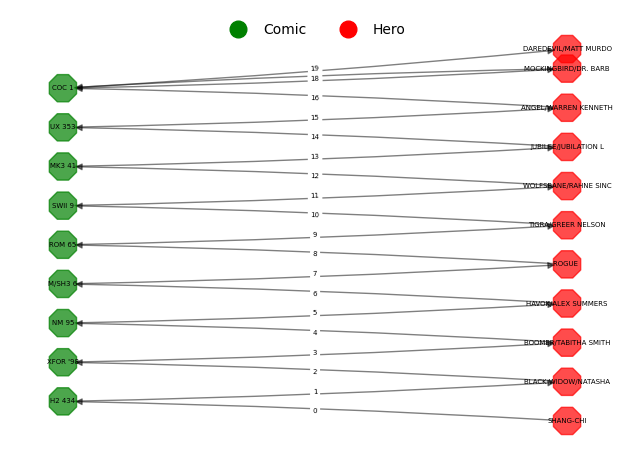

In [141]:
N = 100
h_1, h, h_n = set_h(graph2, len_h=7, N=N)

visualization_3(graph2, h, h_1, h_n, N=N)